In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## Carga dataset

In [ ]:
df_crimes = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_processed.csv")
df_crimes.head()

## Eliminar duplicados

Dada la cantidad de datos con los que se cuenta, se decide eliminar los duplicados detectados durante el EDA.

In [5]:
df_crimes = df_crimes.drop_duplicates()

## Rellenamos nulls de Location Description con nueva categoria UNKNOWN

In [ ]:
df_crimes.isna().sum()

Para poder trabajar con aquellos datos que presentaban valores faltantes en la variable Location Description, imputamos los valores faltantes con la categoría ‘UNKNOWN’ y dejamos el dataset listo para el preprocesamiento.

In [7]:
df_crimes['Location Description'] = df_crimes['Location Description'].fillna('UNKNOWN')

In [8]:
df_crimes.isna().sum()

IUCR                                    0
Primary Type                            0
Location Description                    0
Arrest                                  0
Domestic                                0
Beat                                    0
Ward                                    0
Community Area                          0
FBI Code                                0
X Coordinate                            0
Y Coordinate                            0
Latitude                                0
Longitude                               0
Crime District                          0
Nearest Police Station District         0
Nearest Police Station District Name    0
Distance Crime To Police Station        0
Season                                  0
Day                                     0
Day Time                                0
dtype: int64

## Dataset split

Para evitar un problema de Data Leakage, se divide el dataset en train y test.

Para el presente proyecto, se plantea un problema de clasificación binaria, buscando predecir el valor de la variable target "Arrest". Como se vio durante el EDA el dataset se encuentra desbalanceado respecto de esta variable, por lo que se decide utilizar la técnica de stratify para mantener la proporción de la variable target en ambos datasets.

In [9]:
df, test_df = train_test_split(df_crimes, test_size=0.2, random_state=42, stratify=df_crimes['Arrest'])

print(df.shape, test_df.shape)

(202972, 20) (50744, 20)


In [10]:
df['Arrest'].value_counts()

Arrest
False    175115
True      27857
Name: count, dtype: int64

In [11]:
test_df['Arrest'].value_counts()

Arrest
False    43780
True      6964
Name: count, dtype: int64

## Tratamiento de outliers

Se propone primero aplicar una transformación logarítmica de 'Distance Crime To Police Station' para reducir la asimetría y disminuir la influencia de los valores atípicos.

In [12]:
df_transformed = df.sort_index().copy()
df_transformed['Distance Crime To Police Station'] = np.log1p(df_transformed['Distance Crime To Police Station'])
df_transformed = df_transformed.sort_index()
df_transformed = df_transformed.reset_index(drop=True) 
df_transformed.describe()

# Transformación logarítmica de 'Distance Crime To Police Station' datos de test
test_df_transformed = test_df.sort_index().copy()
test_df_transformed['Distance Crime To Police Station'] = np.log1p(test_df_transformed['Distance Crime To Police Station'])
test_df_transformed = test_df_transformed.sort_index()
test_df_transformed = test_df_transformed.reset_index(drop=True)  

print("Train shape:", df_transformed.shape)
print("Test shape:", test_df_transformed.shape)

Train shape: (202972, 20)
Test shape: (50744, 20)


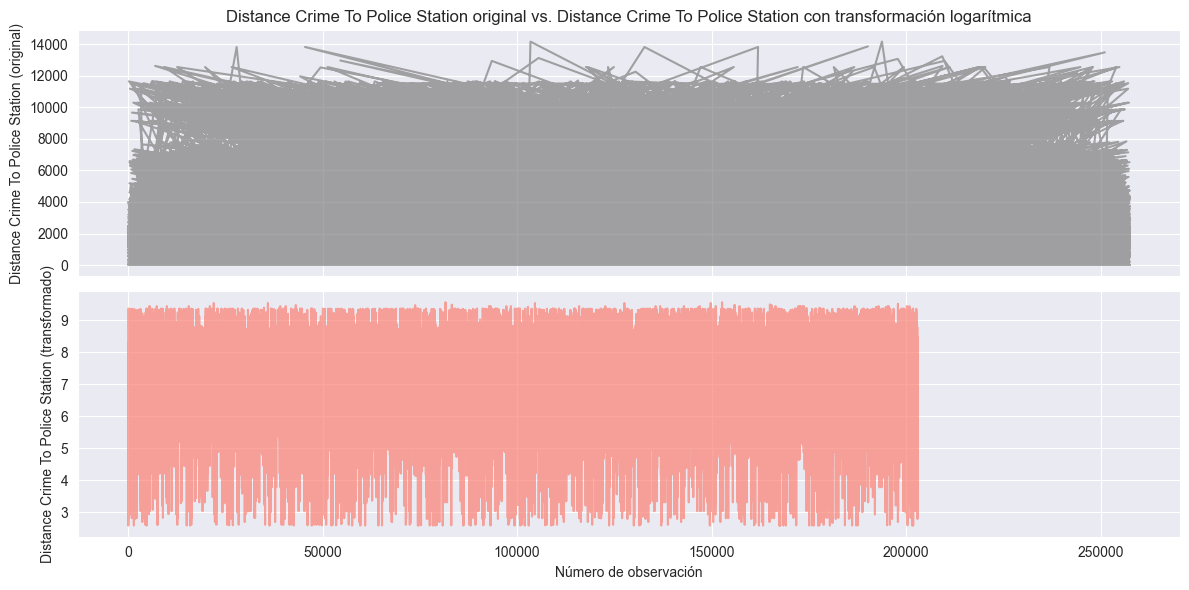

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Primer gráfico: datos originales
axes[0].plot(df.index, df['Distance Crime To Police Station'], alpha=0.7, color='gray')
axes[0].set_ylabel('Distance Crime To Police Station (original)')
axes[0].set_title('Distance Crime To Police Station original vs. Distance Crime To Police Station con transformación logarítmica')

# Segundo gráfico: datos imputados
axes[1].plot(df_transformed.index, df_transformed['Distance Crime To Police Station'], alpha=0.7, color='salmon')
axes[1].set_ylabel('Distance Crime To Police Station (transformado)')
axes[1].set_xlabel('Número de observación')

plt.tight_layout()
plt.show()

En la parte superior (variable original), los valores están muy dispersos y con presencia evidente de picos extremos que distorsionan la escala general. Esto refleja la alta asimetría positiva y la varianza elevada que ya se había identificado.

En la parte inferior (variable transformada), los valores se concentran en un rango mucho más acotado, eliminando la escala exagerada provocada por los outliers. La distribución visual ahora es más homogénea y comprimida, lo que facilita su análisis estadístico y gráfico.

Aplicando la transformación logarítmica se logra:

* Reducir la dispersión y suavizar la cola derecha de la distribución.

* Mitigar el impacto de los valores extremos, haciéndolos más comparables con el resto.

* Mejorar la simetría de la variable, acercándola a un comportamiento más parecido a una distribución normal.

In [20]:
df_for_outliers = df_transformed[['Distance Crime To Police Station']]
Q1 = df_for_outliers.quantile(0.25)
Q3 = df_for_outliers.quantile(0.75)

IQR = Q3 - Q1
outliers_iqr = (df_for_outliers < (Q1 - 1.5 * IQR)) | (df_for_outliers > (Q3 + 1.5 * IQR))
print(f"Outliers\nDistance Crime To Police Station: <{Q1['Distance Crime To Police Station'] - 1.5 * IQR['Distance Crime To Police Station']:.02f} o >{Q3['Distance Crime To Police Station'] + 1.5 * IQR['Distance Crime To Police Station']:.02f}")

Outliers
Distance Crime To Police Station: <6.03 o >8.91


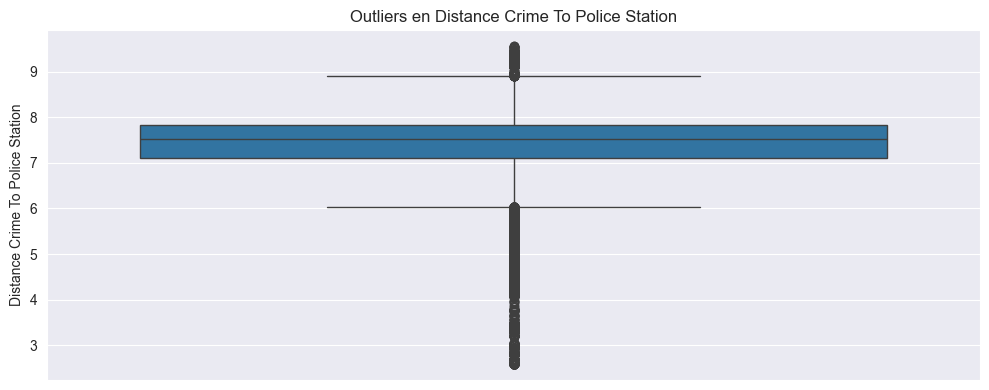

In [21]:
# Visualización de outliers con boxplots
fig, axes = plt.subplots(1, figsize=(10, 4))

# Boxplot para 'Distance Crime To Police Station'
sns.boxplot(y=df_for_outliers['Distance Crime To Police Station'], ax=axes)
axes.set_title('Outliers en Distance Crime To Police Station')

plt.tight_layout()
plt.show()

In [22]:
# Metodo basado en desviación estándar
mean = df_for_outliers.mean()
std = df_for_outliers.std()
# std = df_transformed.apply(lambda x: np.nanstd(x, ddof=1))

outliers_std = (df_for_outliers < (mean - 3 * std)) | (df_for_outliers > (mean + 3 * std))

print(f"Outliers\nDistance Crime To Police Station: <{mean['Distance Crime To Police Station'] - 3 * std['Distance Crime To Police Station']:.02f} o >{mean['Distance Crime To Police Station'] + 3 * std['Distance Crime To Police Station']:.02f}")

Outliers
Distance Crime To Police Station: <5.37 o >9.46


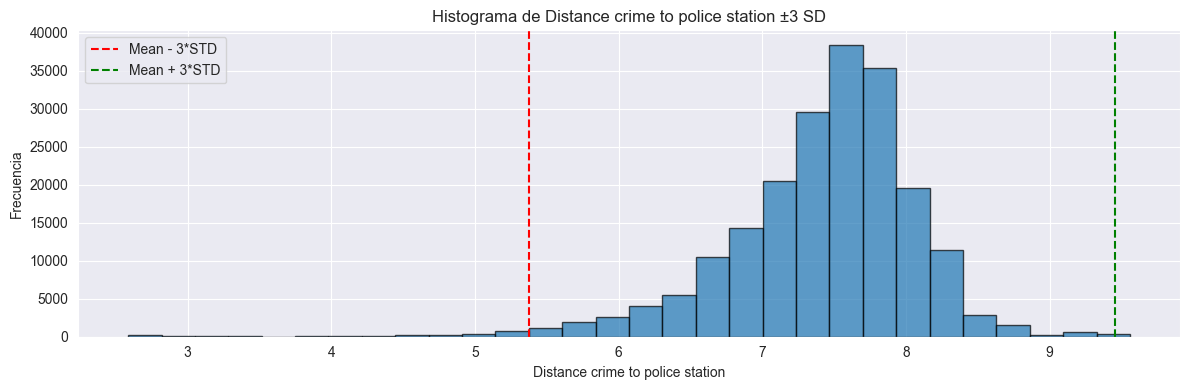

In [23]:
def plot_hist_with_std(ax, data, varname, mean, std):
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(mean[varname] - 3*std[varname], color='red', linestyle='--', label='Mean - 3*STD')
    ax.axvline(mean[varname] + 3*std[varname], color='green', linestyle='--', label='Mean + 3*STD')
    ax.set_xlabel(varname.capitalize())
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Histograma de {varname.capitalize()} ±3 SD')
    ax.legend()

fig, ax = plt.subplots(1, figsize=(12, 4))

plot_hist_with_std(ax, df_for_outliers['Distance Crime To Police Station'], 'Distance Crime To Police Station', mean, std)

plt.tight_layout()
plt.show()

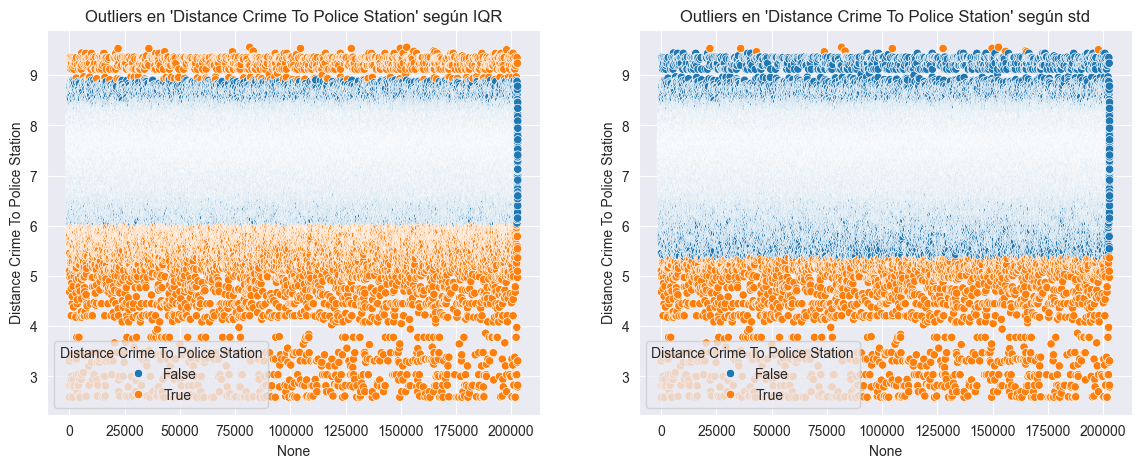

In [24]:
# Visualización con scatterplot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x=df_for_outliers.index, y=df_for_outliers['Distance Crime To Police Station'], hue=outliers_iqr['Distance Crime To Police Station'], ax=ax[0])
ax[0].set_title("Outliers en 'Distance Crime To Police Station' según IQR")
sns.scatterplot(x=df_for_outliers.index, y=df_for_outliers['Distance Crime To Police Station'], hue=outliers_std['Distance Crime To Police Station'], ax=ax[1])
ax[1].set_title("Outliers en 'Distance Crime To Police Station' según std")
plt.show()

El boxplot muestra que la mayoría de las observaciones están concentradas entre los valores 7 y 8 (en escala logarítmica). Sin embargo, aún se observan valores atípicos tanto por debajo como por encima del rango intercuartílico, especialmente en los extremos inferiores.

Aunque la transformación logarítmica redujo la asimetría, no eliminó completamente los outliers, sino que los atenuó y facilitó su identificación.

En el histograma con límites ±3 desviaciones estándar, las líneas punteadas indican los límites de Mean ± 3·STD, una regla común para detectar valores extremos suponiendo una distribución aproximadamente normal.

Se observa que la gran mayoría de los casos se encuentran dentro del rango esperado, con muy pocos valores más allá de ±3σ. Esto sugiere que, bajo el método del desvío estándar, los outliers son escasos y el conjunto de datos está relativamente estabilizado después de la transformación.

El método de detección por desviación estándar es más permisivo y adecuado si se busca conservar más datos en el análisis posterior. Se decide utilizar este método para proceder con la eliminación de estos valores atípicos detectados.


In [25]:
df_no_outliers = df_transformed[~outliers_std.any(axis=1)].copy()
df_no_outliers.describe()

,Beat,Ward,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude,Crime District,Distance Crime To Police Station
count,200526.000000,200526.000000,200526.000000,2.005260e+05,2.005260e+05,200526.000000,200526.000000,200526.000000,200526.000000
mean,1155.124438,23.118633,36.335288,1.165275e+06,1.887516e+06,41.846927,-87.668938,11.321559,7.449605
std,708.398514,13.939783,21.582439,1.621758e+04,3.161830e+04,0.086946,0.051482,7.079151,0.595541
min,111.000000,1.000000,1.000000,1.097306e+06,1.813897e+06,41.644590,-87.768200,1.000000,5.372816
25%,533.000000,10.000000,22.000000,1.153917e+06,1.860269e+06,41.772038,-87.705488,5.000000,7.128335
50%,1033.000000,23.000000,32.000000,1.167075e+06,1.894159e+06,41.865263,-87.656973,10.000000,7.533998
75%,1731.000000,34.000000,53.000000,1.176712e+06,1.910357e+06,41.909852,-87.630560,17.000000,7.831720
max,2535.000000,50.000000,77.000000,1.205119e+06,1.951493e+06,42.022537,-87.568349,31.000000,9.443448


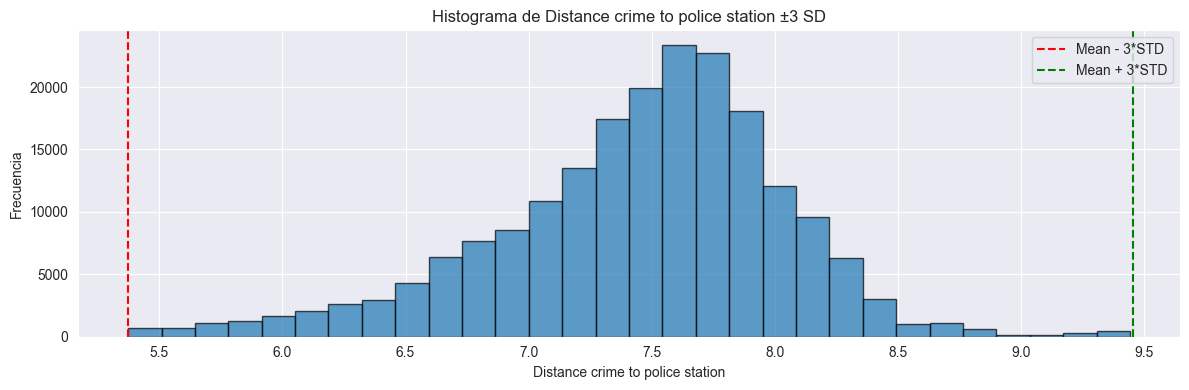

In [26]:
fig, ax = plt.subplots(1, figsize=(12, 4))

plot_hist_with_std(ax, df_no_outliers['Distance Crime To Police Station'], 'Distance Crime To Police Station', mean, std)

plt.tight_layout()
plt.show()

Vemos que ya no existen valores que superen los límites de ±3 desviaciones estándar.

## Codificación (encoding)

Convertimos columnas del dataset al tipo correcto antes de codificarlas

In [31]:
df_no_outliers = df_no_outliers.copy()

df_no_outliers['IUCR'] = df_no_outliers['IUCR'].astype('category')
df_no_outliers['FBI Code'] = df_no_outliers['FBI Code'].astype('category')
df_no_outliers['Primary Type'] = df_no_outliers['Primary Type'].astype('category')
df_no_outliers['Location Description'] = df_no_outliers['Location Description'].astype('category')
df_no_outliers['Arrest'] = df_no_outliers['Arrest'].astype('category')
df_no_outliers['Domestic'] = df_no_outliers['Domestic'].astype('category')
df_no_outliers['Nearest Police Station District Name'] = df_no_outliers['Nearest Police Station District Name'].astype('category')
df_no_outliers['Nearest Police Station District'] = df_no_outliers['Nearest Police Station District'].astype('category')
df_no_outliers['Season'] = df_no_outliers['Season'].astype('category')
df_no_outliers['Day'] = df_no_outliers['Day'].astype('category')
df_no_outliers['Day Time'] = df_no_outliers['Day Time'].astype('category')
df_no_outliers['Beat'] = df_no_outliers['Beat'].astype('category')
df_no_outliers['Ward'] = df_no_outliers['Ward'].astype('category')
df_no_outliers['Community Area'] = df_no_outliers['Community Area'].astype('category')
df_no_outliers['Crime District'] = df_no_outliers['Crime District'].astype('category')

Hacemos los mismo para los valores de test

In [33]:
test_df_transformed['IUCR'] = test_df_transformed['IUCR'].astype('category')
test_df_transformed['FBI Code'] = test_df_transformed['FBI Code'].astype('category')
test_df_transformed['Primary Type'] = test_df_transformed['Primary Type'].astype('category')
test_df_transformed['Location Description'] = test_df_transformed['Location Description'].astype('category')
test_df_transformed['Arrest'] = test_df_transformed['Arrest'].astype('category')
test_df_transformed['Domestic'] = test_df_transformed['Domestic'].astype('category')
test_df_transformed['Nearest Police Station District Name'] = test_df_transformed['Nearest Police Station District Name'].astype('category')
test_df_transformed['Nearest Police Station District'] = test_df_transformed['Nearest Police Station District'].astype('category')
test_df_transformed['Season'] = test_df_transformed['Season'].astype('category')
test_df_transformed['Day'] = test_df_transformed['Day'].astype('category')
test_df_transformed['Day Time'] = test_df_transformed['Day Time'].astype('category')
test_df_transformed['Beat'] = test_df_transformed['Beat'].astype('category')
test_df_transformed['Ward'] = test_df_transformed['Ward'].astype('category')
test_df_transformed['Community Area'] = test_df_transformed['Community Area'].astype('category')
test_df_transformed['Crime District'] = test_df_transformed['Crime District'].astype('category')

### Cyclic Encoding

Como los días de la semana presentan un orden circular, se puede codificar de manera cíclica.

In [34]:
# Codificación cíclica de la variable 'Day' para datos de entrenamiento
df_no_outliers["Day_num"] = df_no_outliers["Day"].map({
    "Sunday": 1, "Monday": 2, "Tuesday": 3, "Wednesday": 4, "Thursday": 5, "Friday": 6, "Saturday": 7
}).astype(int)

In [35]:
# Codificación cíclica de la variable 'Day' para datos de test
test_df_transformed["Day_num"] = test_df_transformed["Day"].map({
    "Sunday": 1, "Monday": 2, "Tuesday": 3, "Wednesday": 4, "Thursday": 5, "Friday": 6, "Saturday": 7
}).astype(int)

In [36]:
df_no_outliers["Day_sin"] = np.sin(2 * np.pi * df_no_outliers["Day_num"] / 7)

In [37]:
test_df_transformed["Day_sin"] = np.sin(2 * np.pi * test_df_transformed["Day_num"] / 7)

### One-Hot encoding datos de entrenamiento


Se propone utilizar one-hot encoding para Season y Day Time, que son variables categóricas de baja cardinalidad.

In [38]:
df_no_outliers = df_no_outliers.reset_index()

In [39]:
# Inicializar el OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop="first")

# Fit + transform
encoded_array = ohe.fit_transform(df_no_outliers[["Season"]])
columns=ohe.get_feature_names_out(["Season"])

# Creo un DF a partir del array
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(["Season"]))

# Lo juntamos con el df original
df_ohe = df_no_outliers.join(encoded_df)

In [44]:
# Inicializar el OneHotEncoder
ohe_2 = OneHotEncoder(sparse_output=False, drop='first')

# Fit + transform
encoded_array = ohe_2.fit_transform(df_ohe[["Day Time"]])
columns=ohe_2.get_feature_names_out(["Day Time"])

# Creo un DF a partir del array
encoded_df = pd.DataFrame(encoded_array, columns=ohe_2.get_feature_names_out(["Day Time"]))

# Lo juntamos con el df original
df_ohe_2 = df_ohe.join(encoded_df)

### One-Hot encoding datos de test


In [45]:
test_df_transformed = test_df_transformed.reset_index()

In [46]:
# transform
encoded_test_array = ohe.transform(test_df_transformed[["Season"]])
test_columns = ohe.get_feature_names_out(["Season"])

# Creo un DF a partir del array
encoded_test_df = pd.DataFrame(encoded_test_array, columns=test_columns)

# Lo juntamos con el df original
test_df_ohe = test_df_transformed.join(encoded_test_df)

In [47]:
# transform
encoded_test_array = ohe_2.transform(test_df_ohe[["Day Time"]])
test_columns=ohe_2.get_feature_names_out(["Day Time"])

# Creo un DF a partir del array
encoded_test_df = pd.DataFrame(encoded_test_array, columns=test_columns)

# Lo juntamos con el df original
test_df_ohe_2 = test_df_ohe.join(encoded_test_df)

### Label encoding


Para las variables booleanas Arrest y Domestic se propone utilizar Label encoding, asignando el valor 0 a False y 1 a True.

In [48]:
df_label = df_ohe_2.copy()
test_df_label = test_df_ohe_2.copy()

In [49]:
df_label["Arrest_tag"] = df_label["Arrest"].astype(int)
df_label["Domestic_tag"] = df_label["Domestic"].astype(int)

test_df_label["Arrest_tag"] = test_df_label["Arrest"].astype(int)
test_df_label["Domestic_tag"] = test_df_label["Domestic"].astype(int)

In [50]:
columns_to_drop = ["Season", "Day", "Day_num", "Day Time", "index", "Arrest", "Domestic"]
df_label = df_label.drop(columns=columns_to_drop)
test_df_label = test_df_label.drop(columns=columns_to_drop)

### Frequency Encoding


Para las variables de mayor cardinalidad "IUCR", "Primary Type", "Location Description", "FBI Code", "Crime District", "Nearest Police Station District", "Nearest Police Station District Name" se propone utilizar Frequency encoding.

In [51]:
df_freq = df_label.copy()
test_df_freq = test_df_label.copy()

In [52]:
# Variables a ser codificadas con Frequency Encoding
categorical_cols = ["IUCR", "Primary Type", "Location Description", "FBI Code",
                      "Crime District", "Nearest Police Station District",
                      "Nearest Police Station District Name"]

test_df_freq[categorical_cols] = test_df_freq[categorical_cols].astype('object')

# Frequency encoding
for col in categorical_cols:
    freq_encoding = df_freq[col].value_counts(normalize=True)

    # Train
    df_freq[f"{col.replace(' ', '_')}_freq"] = df_freq[col].map(freq_encoding).astype(float)

    # Test con fillna
    test_df_freq[f"{col.replace(' ', '_')}_freq"] = test_df_freq[col].map(freq_encoding).fillna(0).astype(float)


In [53]:
columns_to_drop = ["IUCR", "Primary Type", "Location Description", "FBI Code", "Crime District", "Nearest Police Station District", "Nearest Police Station District Name"]
df_freq = df_freq.drop(columns=columns_to_drop)
test_df_freq = test_df_freq.drop(columns=columns_to_drop)

## Salvamos en un archivo

Una vez completado el procesamiento, salvamos el dataset procesado en un archivo csv

In [54]:
df_freq.to_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded.csv", index=False)
test_df_freq.to_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded_test.csv", index=False)